<a href="https://colab.research.google.com/github/Vkgo2309/Assignment-1/blob/main/Item_Demand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
import math
import plotly.graph_objects as go
from google.colab import files
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing 
from sklearn import neighbors, tree, ensemble, linear_model
import datetime as dt
import xgboost as xgb
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.1f}'.format

In [2]:
data= files.upload()


Saving train (2).csv to train (2).csv


In [3]:
data1= files.upload()

Saving test .csv to test .csv


In [94]:
train_df = pd.read_csv('/content/train (2).csv')
test_df = pd.read_csv('/content/test .csv')

Converting date data to month year and week. 

In [93]:
train_df['date'] = pd.to_datetime(train_df.date)
train_df['month'] = train_df.date.dt.month
train_df['year'] = train_df.date.dt.year
train_df['dayofweek'] = train_df.date.dt.dayofweek
# train_df.head()
test_df['date'] = pd.to_datetime(test_df.date)
test_df['month'] = test_df.date.dt.month
test_df['year'] = test_df.date.dt.year
test_df['dayofweek'] = test_df.date.dt.dayofweek


<!-- # 1. Data Analysis -->

### 1.1 Extracting info


In [95]:
print('train_df info')
print(train_df.info())
print('')
print('train_df describe')
print(train_df.describe())

train_df info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

train_df describe
         store     item    sales
count 913000.0 913000.0 913000.0
mean       5.5     25.5     52.3
std        2.9     14.4     28.8
min        1.0      1.0      0.0
25%        3.0     13.0     30.0
50%        5.5     25.5     47.0
75%        8.0     38.0     70.0
max       10.0     50.0    231.0


### 1.2 Graphs

Representation of data in possible graphs

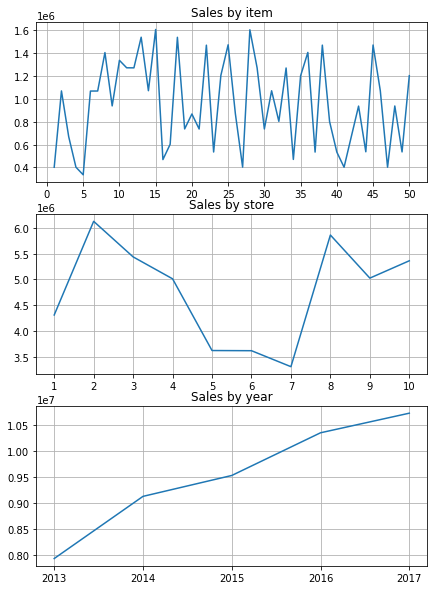

In [9]:
plt.figure(figsize=(7, 10))

plt.subplot(311)
plt.xticks(range(0, 55, 5))
plt.grid()
plt.title('Sales by item')
_ = plt.plot(train_df.groupby(['item'])['sales'].sum())

plt.subplot(312)
plt.xticks(range(1, 11))
plt.grid()
plt.title('Sales by store')
_ = plt.plot(train_df.groupby(['store'])['sales'].sum())

plt.subplot(313)
plt.xticks(range(2013, 2018))
plt.grid()
plt.title('Sales by year')
_ = plt.plot(train_df.groupby(train_df.date.dt.year)['sales'].sum())

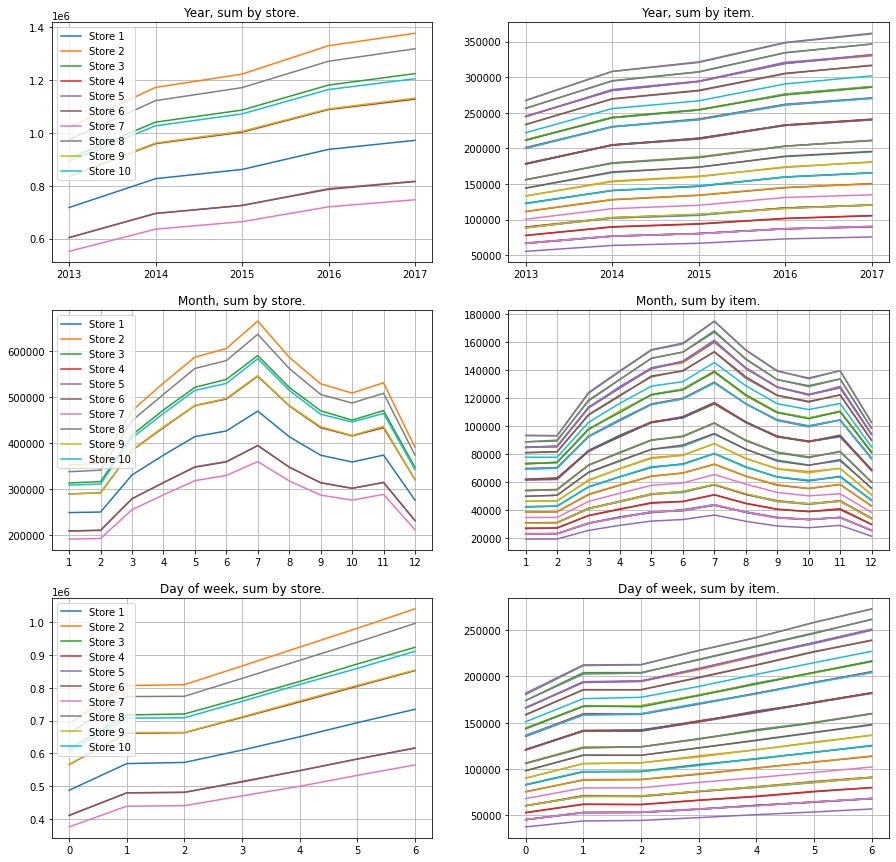

In [10]:
plt.figure(figsize=(15, 15))

plt.subplot(321)
for i in range(1, 11):
    plt.plot(train_df.sales[(train_df.store == i) ].groupby(train_df.date.dt.year).sum(), label='Store ' + str(i))
plt.title('Year, sum by store.')
plt.xticks(range(2013, 2018))
plt.grid()
plt.legend(loc='upper left')

plt.subplot(322) 
for i in range(1, 51):
    plt.plot(train_df.sales[(train_df.item == i) ].groupby(train_df.date.dt.year).sum(), label='Item' + str(i))
plt.title('Year, sum by item.')
plt.xticks(range(2013, 2018))
plt.grid()

plt.subplot(323)
for i in range(1, 11):
    plt.plot(train_df.sales[(train_df.store == i)].groupby(train_df.date.dt.month).sum(), label='Store ' + str(i))
plt.title('Month, sum by store.')
plt.xticks(range(1, 13))
plt.grid()
plt.legend(loc='upper left')

plt.subplot(324)
for i in range(1, 51):
    plt.plot(train_df.sales[(train_df.item == i)].groupby(train_df.date.dt.month).sum(), label='Item ' + str(i))
plt.title('Month, sum by item.')
plt.xticks(range(1, 13))
plt.grid()

plt.subplot(325)
for i in range(1, 11):
    plt.plot(train_df.sales[(train_df.store == i)].groupby(train_df.date.dt.dayofweek).sum(), label='Store ' + str(i))
plt.title('Day of week, sum by store.')
plt.grid()
plt.legend(loc='upper left')

plt.subplot(326)
for i in range(1, 51):
    _ = plt.plot(train_df.sales[(train_df.item == i)].groupby(train_df.date.dt.dayofweek).sum(), label='Item ' + str(i))
plt.title('Day of week, sum by item.')
plt.grid()

### 1.3 Scatter plot

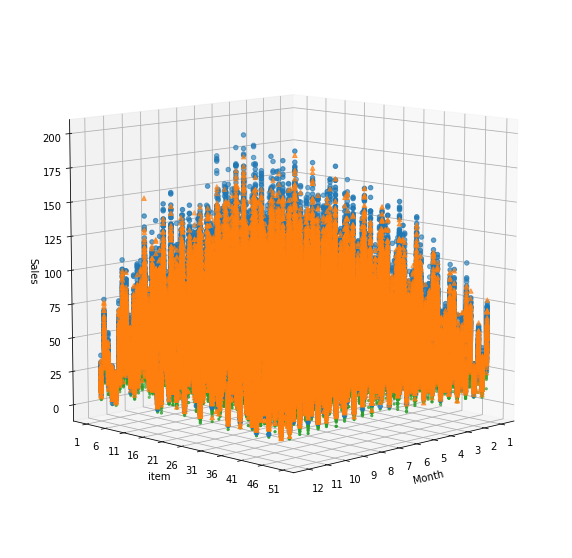

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mark = ['', 'o', '^', '.', 'x', '^', 'o', '^', '.', 'x', 'o']
for i in range(1, 4):
    ax.scatter(train_df.date.dt.month[train_df.store == i+2], 
               train_df.item[train_df.store == i+2], 
               train_df.sales[train_df.store == i+2], marker=mark[i])

plt.xticks(range(1, 13))
plt.yticks(range(1, 55, 5))

ax.set_xlabel('Month')
ax.set_ylabel('item')
ax.set_zlabel('Sales')  
ax.view_init(elev=10., azim=45)

# 2. Preparation

### 2.1 Training and validation data

In [12]:
features = train_df.drop(['date', 'sales'], 1)
targets = train_df['sales']

features = preprocessing.StandardScaler().fit_transform(features.values)

X_test = pd.DataFrame(preprocessing.StandardScaler().fit_transform(test_df.drop(['date'], 1).values),
                      index=test_df.drop(['date'], 1).index,
                      columns=test_df.drop(['date'], 1).columns)

folds = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

### 2.2 Class estimator (sklearn)

Creating a class to use with sklearn model


In [13]:
class SKLEstimator:    

    def __init__(self, estimator, param_grid, folds=folds, verbose=0):
        self.grid = model_selection.GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='neg_mean_squared_error', cv=folds, verbose=verbose, n_jobs=-1)
        self.estimator = estimator
    
    def fit_grid(self, X, y=targets, verbose=False):
        self.grid.fit(X, y)
        if verbose:
            print('')
            print('Best score: {:.2f}'.format(math.sqrt(abs(self.grid.best_score_))))
            print('Best parameters: {}'.format(self.grid.best_params_))
      
    def get_best_estimator(self):
        return self.grid.best_estimator_
 

    def best_params(self):
        return self.grid.best_params_
      
    def train_estimator(self, X, y=targets, folds=folds, verbose=False):
        scores = []
        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

            self.grid.best_estimator_.fit(X_train, y_train)
            y_pred_valid = self.grid.best_estimator_.predict(X_valid).reshape(-1)

            scores.append(metrics.mean_squared_error(y_valid, y_pred_valid))
        if verbose:
            print('Mean of CV MSE scores (on train/valid set): {0:.2f}'.format(math.sqrt(abs(np.mean(scores)))))  
      
        return scores
    
    def predict_targets(self, X_test):
        return self.grid.best_estimator_.predict(X_test)    
    
    @property
    def best_score(self):
      return math.sqrt(abs(self.grid.best_score_))

# 3. Models

### 3.1 Linear regression model

In [96]:
grid_linreg = {'fit_intercept': [True, False]}
linreg_estim = SKLEstimator(linear_model.LinearRegression(), grid_linreg)
linreg_estim.fit_grid(features, verbose=True)


Best score: 27.42
Best parameters: {'fit_intercept': True}


The score we obtained from the Linear regression model in "27.42".

### 3.2 KNN regression model

In [15]:
grid_knn = {'n_neighbors': [10],
            'weights': ['distance'],
            'algorithm': ['kd_tree']}
knn_estim = SKLEstimator(neighbors.KNeighborsRegressor(), grid_knn, folds=folds, verbose=1)
knn_estim.fit_grid(features, verbose=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score: 8.83
Best parameters: {'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}


The score obtained from the KNN regression model is "8.83".

### 3.3 Decision Tree model

In [97]:
grid_dt = {'splitter': ['best'],
           'min_samples_split': [10],
           'min_samples_leaf': [5],
           'min_weight_fraction_leaf': [0],    
          }
dt_estim = SKLEstimator(tree.DecisionTreeRegressor(), grid_dt, verbose=1)
dt_estim.fit_grid(features, verbose=True) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score: 8.08
Best parameters: {'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


The Score obtained from the Decision Tree model is "8.08"

### 3.4 Random Forest Regression model

In [17]:
grid_rf = {'n_estimators': [10],
           'max_depth': [None],
           'min_samples_split': [2],
           'min_samples_leaf': [5],
           'min_weight_fraction_leaf': [0]}

folds = model_selection.KFold(n_splits=2, shuffle=True, random_state=42)

rf_estim = SKLEstimator(ensemble.RandomForestRegressor(), grid_rf, folds=folds, verbose=1)
rf_estim.fit_grid(features, verbose=True) 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best score: 7.84
Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 10}


The score obtained from the Random Forest Regression model is "7.84".

# 4. Conclusions

In [98]:
print(linreg_estim.best_score)
print(knn_estim.best_score)
print(dt_estim.best_score)
print(rf_estim.best_score)

27.421781630608784
8.82625214265836
8.077453630669362
7.839879165673898


#**5. Predictions**

In [99]:
def submit_preds(estimator, name, X_test, submit_df, to_csv=False):

    submit_df['sales'] = estimator.predict_targets(X_test).astype(int) 
    name_csv = name + ".csv"
    
    if to_csv:
        submit_df.to_csv(name_csv, index=False)
    
    return submit_df

In [101]:
new_test_df = submit_preds(rf_estim, 'test_df', X_test, test_df, to_csv=True)
#new_test_df.sort_values(by='month', inplace=True)
new_test_df

,date,store,item,sales
0,01-01-2018,1,1,15
1,02-01-2018,1,1,21
2,03-01-2018,1,1,24
3,04-01-2018,1,1,30
4,05-01-2018,1,1,20
...,...,...,...,...
44995,27-03-2018,10,50,80
44996,28-03-2018,10,50,85
44997,29-03-2018,10,50,89
44998,30-03-2018,10,50,94


In [119]:
daily_sales_sc = go.Scatter(x=train_df[-92:]['date'], y=train_df[-92:]['sales'])
daily_sales_pc = go.Scatter(x=new_test_df[-90:]['date'], y=new_test_df[-90:]['sales'])
layout = go.Layout(title='DAILY SALES', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_pc,daily_sales_sc], layout=layout)
fig.show()

